In [12]:
!gdown https://drive.google.com/uc?id=1v36q7Efz0mprjAv4g6TkQM2YlDKdqOuy

Downloading...
From: https://drive.google.com/uc?id=1v36q7Efz0mprjAv4g6TkQM2YlDKdqOuy
To: /content/IMDB-Dataset.csv
100% 66.2M/66.2M [00:01<00:00, 46.6MB/s]


In [13]:
%pip install -q contractions

In [14]:
# Load dataset
import pandas as pd

df = pd.read_csv('./IMDB-Dataset.csv')

# Remove duplicate rows
df = df.drop_duplicates()

# Data cleaning steps, including removing HTML tags, numbers, icons, etc.

import re
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import contractions

stop = set(stopwords.words('english'))

# Expanding contractions
def expand_contractions(text):
    return contractions.fix(text)

# Function to clean data
def preprocess_text(text):
    wl = WordNetLemmatizer()

    # Removing html tags
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()

    # Expanding chat words and clearing contractions
    text = expand_contractions(text)

    # Removing emoticons
    emoji_clean = re.compile("["
                             u"\U0001F600-\U0001F64F"  # emoticons
                             u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                             u"\U0001F680-\U0001F6FF"  # transport & map symbols
                             u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                             u"\U00002702-\U000027B0"
                             u"\U000024C2-\U0001F251"
                             "]+", flags=re.UNICODE)
    text = emoji_clean.sub(r'', text)

    # Adding space after full stop
    text = re.sub(r'\.(?=\S)', '. ', text)

    # Removing URLs
    text = re.sub(r'http\S+', '', text)

    # Removing punctuation and making text lowercase
    text = "".join([word.lower() for word in text if word not in string.punctuation])

    # Lemmatizing words and removing stopwords and non-alphabetic characters
    text = " ".join([wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()])

    return text

# Applying the preprocess function to the 'review' column
df['review'] = df['review'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-14-738d373d0d58>:32: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [15]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['review'])
len(vectorizer.vocabulary_)

143145

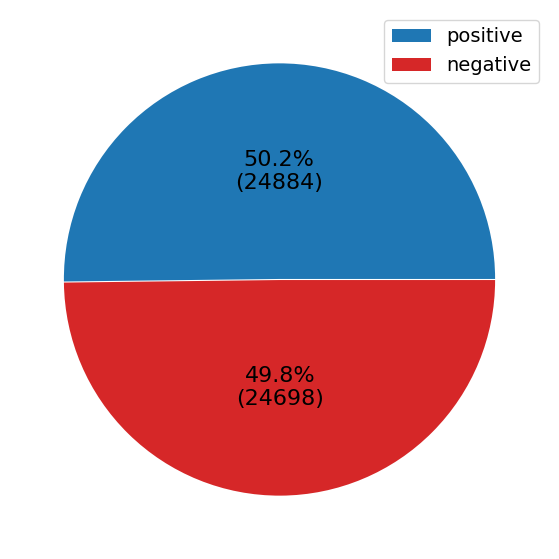

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Creating autopct arguments
def func(pct, allvalues):
    absolute = int(pct / 100. * np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Count frequencies of positive and negative sentiments
freq_pos = len(df[df['sentiment'] == 'positive'])
freq_neg = len(df[df['sentiment'] == 'negative'])

# Data for the pie chart
data = [freq_pos, freq_neg]

# Labels for the chart
labels = ['positive', 'negative']

# Create pie chart
pie, ax = plt.subplots(figsize=[11, 7])
plt.pie(x=data, autopct=lambda pct: func(pct, data), explode=[0.0025] * 2,
        pctdistance=0.5, colors=[sns.color_palette()[0], 'tab:red'], textprops={'fontsize': 16})

# Adding title (commented out in your code)
# plt.title('Frequencies of sentiment labels', fontsize=14, fontweight='bold')

# Adding legend
plt.legend(labels, loc="best", prop={'size': 14})

# Save the pie chart
plt.savefig("PieChart.png")

# Show the pie chart
plt.show()

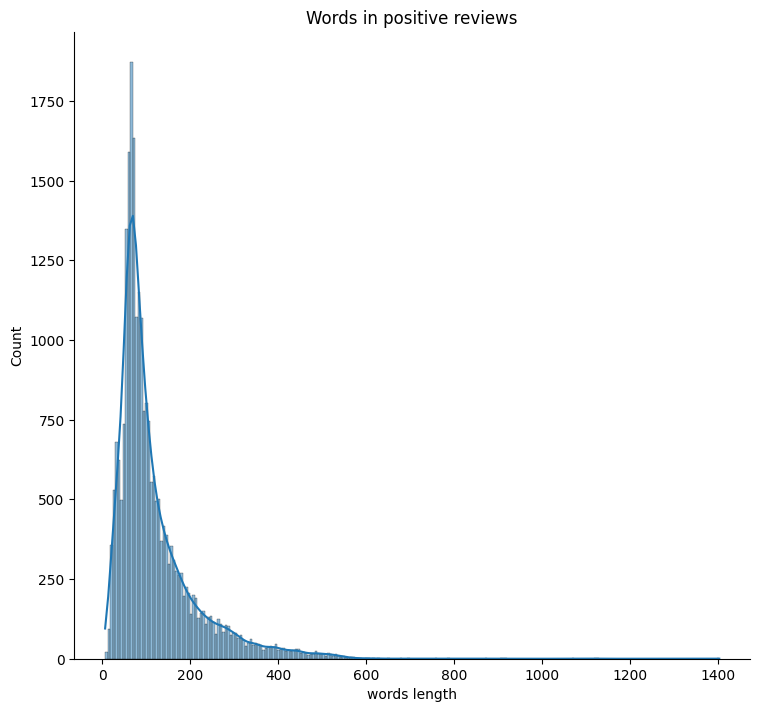

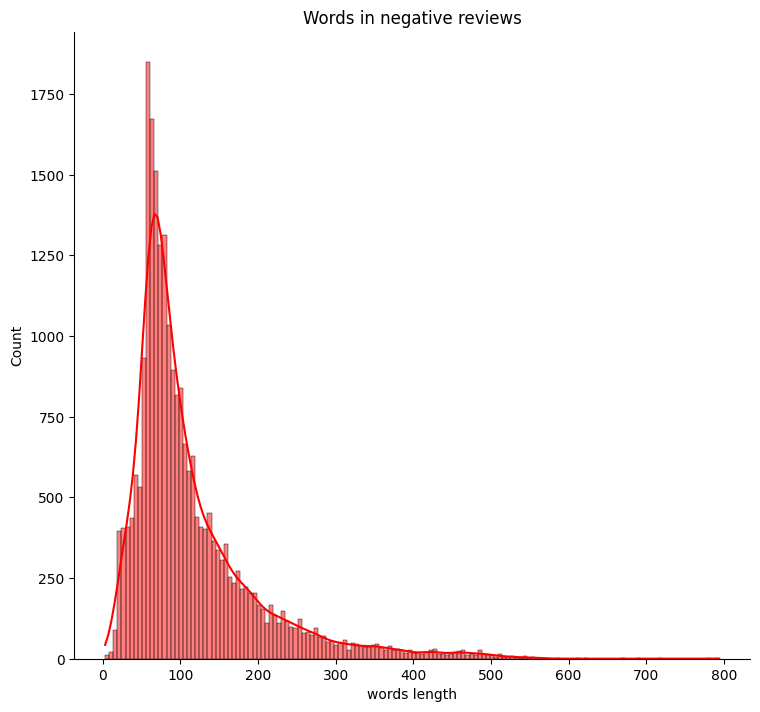

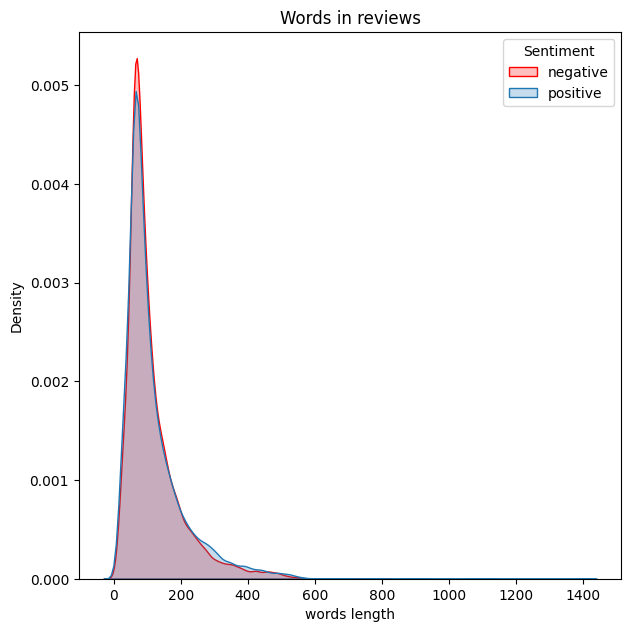

In [ ]:
# Calculate the length of words in each review
words_len = df['review'].str.split().map(lambda x: len(x))
df_temp = df.copy()
df_temp['words length'] = words_len

# Plot for positive reviews
hist_positive = sns.displot(
    data=df_temp[df_temp['sentiment'] == 'positive'],
    x="words length", hue="sentiment", kde=True, height=7, aspect=1.1, legend=False
).set(title='Words in positive reviews')
plt.show(hist_positive)

# Plot for negative reviews
hist_negative = sns.displot(
    data=df_temp[df_temp['sentiment'] == 'negative'],
    x="words length", hue="sentiment", kde=True, height=7, aspect=1.1, legend=False, palette=['red']
).set(title='Words in negative reviews')
plt.show(hist_negative)

# Combined KDE plot for words length distribution across sentiments
plt.figure(figsize=(7, 7.1))
kernel_distibution_number_words_plot = sns.kdeplot(
    data=df_temp, x="words length", hue="sentiment", fill=True, palette=[sns.color_palette()[0], 'red']
).set(title='Words in reviews')
plt.legend(title='Sentiment', labels=['negative', 'positive'])
plt.show(kernel_distibution_number_words_plot)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Encoding labels
label_encode = LabelEncoder()
y_data = label_encode.fit_transform(df['sentiment'])

# Splitting data into train and test sets
x_data = df['review']
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42
)

# Vectorizing text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(x_train, y_train)

x_train_encoded = tfidf_vectorizer.transform(x_train)
x_test_encoded = tfidf_vectorizer.transform(x_test)

# Training and evaluating the Decision Tree model
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt_classifier = DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)
dt_classifier.fit(x_train_encoded, y_train)
y_pred = dt_classifier.predict(x_test_encoded)
accuracy_score(y_pred, y_test)

# Training and evaluating the Random Forest model
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(
    random_state=42
)
rf_classifier.fit(x_train_encoded, y_train)
y_pred = rf_classifier.predict(x_test_encoded)
accuracy_score(y_pred, y_test)


0.8420893415347384